### Importing training and testing csv file

In [1]:
import pandas as pd
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
print(train_df.shape)
print(test_df.shape)

(891, 12)
(418, 11)


## Preprocessing data
* Adding a column dependent based on Parch + SibSp
* Replacing male and felame value with 1 and 2 respectively
* Dropping column 'Ticket', 'Fare', 'Cabin', 'Embarked','Name','Parch','SibSp'

In [2]:
train_df['Dependent'] = train_df.Parch + train_df.SibSp
test_df['Dependent'] = test_df.Parch + test_df.SibSp

train_df = train_df.replace(['female','male'],[20,10])
test_df = test_df.replace(['female','male'],[20,10])

test_PassengerId = test_df.PassengerId

train_df.drop(columns=['Ticket', 'Fare', 'Cabin', 'Embarked','Name','Parch','SibSp','PassengerId'], inplace=True)
test_df.drop(columns=['Ticket', 'Fare', 'Cabin', 'Embarked','Name','Parch','SibSp','PassengerId'], inplace=True)

* Finding categorical age mean and standard devation from Training data based on Survived or Not
* Finding average age and standard deviation of test data for future prediction

In [3]:
dead_mean = train_df.loc[train_df['Survived']==0].Age.mean()
dead_std = train_df.loc[train_df['Survived']==0].Age.std()
live_mean = train_df.loc[train_df['Survived']==1].Age.mean()
live_std = train_df.loc[train_df['Survived']==1].Age.std()
print(dead_mean,dead_std)
print(live_mean, live_std)

test_age_mean = test_df.Age.mean()
test_age_std = test_df.Age.std()
print(test_age_mean,test_age_std)

30.62617924528302 14.17210987713849
28.343689655172415 14.950951984140426
30.272590361445783 14.18120923562442


### Replacing NaN in Age with random value from the distribution

In [4]:
import numpy as np
train_df.Age.fillna(train_df.Survived, inplace=True )
train_df.Age.replace({
    0.0 : round(np.random.normal(dead_mean,dead_std),1),
    1.0 : round(np.random.normal(live_mean,live_std),1)
}, inplace = True)

test_df.Age.fillna(round(np.random.normal(test_age_mean,test_age_std),1),inplace=True)

print(train_df.shape)
print(test_df.dropna().shape)

(891, 5)
(418, 4)


* Converting Survived Column as training label

In [5]:
train_label = train_df.Survived.to_numpy()
train_label = train_label.reshape(train_label.shape[0],1)

train_df.drop(columns=['Survived'], inplace=True)

In [6]:
train_set = train_df.to_numpy()
test_set = test_df.to_numpy()

print ("Training data Size : ", train_set.shape)
print ("Test data Size : ", test_set.shape)

Training data Size :  (891, 4)
Test data Size :  (418, 4)


* Importing required Keras libraries 
* Building the FC model
* Compiing the Model.
* Training the model
* Saving the model

In [7]:
import keras
from keras import layers
from keras import regularizers
from keras import initializers
from keras.layers import Input, Dense, Flatten
from keras.models import Model
import keras.backend as K
K.set_image_data_format('channels_last')

Using TensorFlow backend.


In [8]:
def FCModel(input_shape):
   X_input = Input(input_shape)
   X = X_input
   X = Dense(16, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0))(X)
   X = Dense(8, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0))(X)
   X = Dense(4, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0))(X)
   X = Dense(2, activation='softmax', name='fc7')(X)

   model = Model(inputs = X_input, outputs = X, name='FCModel')

   return model

In [9]:
MyModel = FCModel(train_set.shape[1:])
MyModel.compile(optimizer = 'adam', loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
taining_result = MyModel.fit(x = train_set*0.01, y = train_label, epochs = 320, validation_split= 0.1)

Train on 801 samples, validate on 90 samples
Epoch 1/320
801/801 [==============================] - 1s 2ms/step - loss: 0.6847 - accuracy: 0.6155 - val_loss: 0.6790 - val_accuracy: 0.6222
Epoch 2/320
801/801 [==============================] - 0s 116us/step - loss: 0.6760 - accuracy: 0.6155 - val_loss: 0.6734 - val_accuracy: 0.6222
Epoch 3/320
801/801 [==============================] - 0s 102us/step - loss: 0.6702 - accuracy: 0.6155 - val_loss: 0.6683 - val_accuracy: 0.6222
Epoch 4/320
801/801 [==============================] - 0s 102us/step - loss: 0.6644 - accuracy: 0.6155 - val_loss: 0.6622 - val_accuracy: 0.6222
Epoch 5/320
801/801 [==============================] - 0s 112us/step - loss: 0.6607 - accuracy: 0.6155 - val_loss: 0.6597 - val_accuracy: 0.6222
Epoch 6/320
801/801 [==============================] - 0s 109us/step - loss: 0.6569 - accuracy: 0.6155 - val_loss: 0.6564 - val_accuracy: 0.6222
Epoch 7/320
801/801 [==============================] - 0s 105us/step - loss: 0.6527 - a

### Slowing the goodness of the training

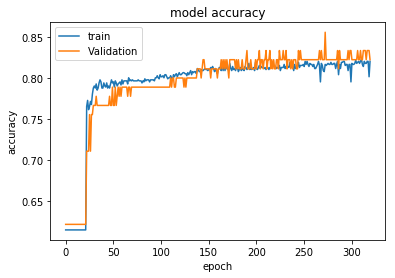

In [10]:
import matplotlib.pyplot as plt
# %matplotlib inline

plt.plot(taining_result.history['accuracy'])
plt.plot(taining_result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

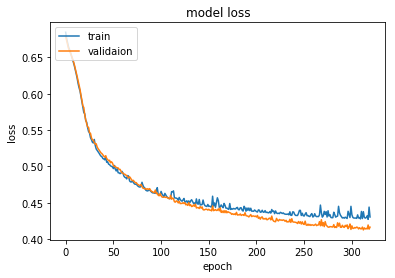

In [11]:
plt.plot(taining_result.history['loss'])
plt.plot(taining_result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validaion'], loc='upper left')
plt.show()

In [12]:
MyModel.save('TitanicPredict_SimpleNeuralNetwork.h5')

* Predicting on test data

In [13]:
predictions = np.argmax(MyModel.predict(test_set*0.01), axis = -1)

In [14]:
myTitanicPreiction_df = pd.DataFrame()
myTitanicPreiction_df['PassengerId'] = test_PassengerId
myTitanicPreiction_df['Survived'] = pd.DataFrame(predictions)
myTitanicPreiction_df.Survived.value_counts()

0    268
1    150
Name: Survived, dtype: int64

### Writing output

In [15]:
myTitanicPreiction_df.to_csv('MyPrediction_submission.csv', index=False)